# Imports

In [20]:
import math
import pandas as pd
import pennylane as qml

from matplotlib import pyplot as plt
from pennylane import numpy as np
from pennylane.templates import AmplitudeEmbedding, AngleEmbedding
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model Params

In [21]:
np.random.seed(42)
initial_params = np.random.random([7])

CLASS_TO_IGNORE = 0  # first class, 0, 1, 2
INITIALIZATION_METHOD = 'Angle'
EPOCHS = 1000
TEST_SIZE = 0.33
STEP_SIZE = 0.01
STEPS = int((1-TEST_SIZE)*100*EPOCHS)

# Import dataset

In [22]:
X, y = load_iris(return_X_y=True)

if CLASS_TO_IGNORE == 0:
    # Drop first class
    X = X[50:]
    y = y[50:]
    y_scaled = np.where(y == 1, -1, y)
    y_scaled = np.where(y_scaled == 2, 1, y_scaled)

elif CLASS_TO_IGNORE == 1:
    # Drop second class
    X = np.delete(X, range(50, 100))
    y = np.delete(y, range(50, 100))
    y_scaled = np.where(y == 0, -1, y)
    y_scaled = np.where(y_scaled == 2, 1, y_scaled)

else:
    # Drop third class
    X = X[:100]
    y = y[:100]
    y_scaled = np.where(y == 0, -1, y)

In [23]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=TEST_SIZE, shuffle=True)

# Circuit creation

In [24]:
device = qml.device("default.qubit", wires=4)

In [25]:
@qml.qnode(device)
def circuit(features, params):
    # Load state
    if INITIALIZATION_METHOD == 'Amplitude':
        AmplitudeEmbedding(features=features, wires=range(4), normalize=True, pad_with=0.)
    else:
        AngleEmbedding(features=features, wires=range(4), rotation='Y')

    # First layer
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.RY(params[3], wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[3, 2])

    # Second layer
    qml.RY(params[4], wires=1)
    qml.RY(params[5], wires=2)
    qml.CNOT(wires=[1, 2])

    # Third layer
    qml.RY(params[6], wires=2)

    # Measurement
    return qml.expval(qml.PauliZ(2))

## Circuit example

In [26]:
features = X_train[0]
print(f"Inital parameters: {initial_params}\n")
print(f"Example features: {features}\n")
print(f"Expectation value: {circuit(features, initial_params)}\n")
print(circuit.draw())

Inital parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361]

Example features: [ 0.20924564 -0.21746808  0.84485761  1.23982783]

Expectation value: -0.13541163118275878

 0: ──RY(0.209)───RY(0.375)──╭C─────────────────────────────┤     
 1: ──RY(-0.217)──RY(0.951)──╰X──RY(0.156)──╭C──────────────┤     
 2: ──RY(0.845)───RY(0.732)──╭X──RY(0.156)──╰X──RY(0.0581)──┤ ⟨Z⟩ 
 3: ──RY(1.24)────RY(0.599)──╰C─────────────────────────────┤     



# Training

In [27]:
params = initial_params
opt = qml.GradientDescentOptimizer(stepsize=STEP_SIZE)
EPOCH_SIZE = len(X_train)

for i in range(STEPS):
    features = X_train[i%EPOCH_SIZE]
    expected_value = y_train[i%EPOCH_SIZE]

    def cost(circuit_params):
        value = circuit(features, circuit_params)
        return ((expected_value - value) ** 2)/len(X_train)

    params = opt.step(cost, params)
    if i % EPOCH_SIZE == 0:
        print(f"epoch {i//EPOCH_SIZE}")

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110


epoch 831
epoch 832
epoch 833
epoch 834
epoch 835
epoch 836
epoch 837
epoch 838
epoch 839
epoch 840
epoch 841
epoch 842
epoch 843
epoch 844
epoch 845
epoch 846
epoch 847
epoch 848
epoch 849
epoch 850
epoch 851
epoch 852
epoch 853
epoch 854
epoch 855
epoch 856
epoch 857
epoch 858
epoch 859
epoch 860
epoch 861
epoch 862
epoch 863
epoch 864
epoch 865
epoch 866
epoch 867
epoch 868
epoch 869
epoch 870
epoch 871
epoch 872
epoch 873
epoch 874
epoch 875
epoch 876
epoch 877
epoch 878
epoch 879
epoch 880
epoch 881
epoch 882
epoch 883
epoch 884
epoch 885
epoch 886
epoch 887
epoch 888
epoch 889
epoch 890
epoch 891
epoch 892
epoch 893
epoch 894
epoch 895
epoch 896
epoch 897
epoch 898
epoch 899
epoch 900
epoch 901
epoch 902
epoch 903
epoch 904
epoch 905
epoch 906
epoch 907
epoch 908
epoch 909
epoch 910
epoch 911
epoch 912
epoch 913
epoch 914
epoch 915
epoch 916
epoch 917
epoch 918
epoch 919
epoch 920
epoch 921
epoch 922
epoch 923
epoch 924
epoch 925
epoch 926
epoch 927
epoch 928
epoch 929
epoch 930


In [28]:
print("Optimized rotation angles: {}".format(params))

Optimized rotation angles: [ 0.26159806  1.41156839  0.23155153  0.86072341  0.87603138 -0.34209155
 -1.33214815]


# Testing

In [29]:
prediction_class = np.array([])
prediction_values = np.array([])
for example, example_class in zip(X_test, y_test):
    predicted_value = circuit(example, params)
    prediction_values = np.append(prediction_values, predicted_value)

    if predicted_value <= 0:
        prediction_class = np.append(prediction_class, -1)
    else:
        prediction_class = np.append(prediction_class, 1)

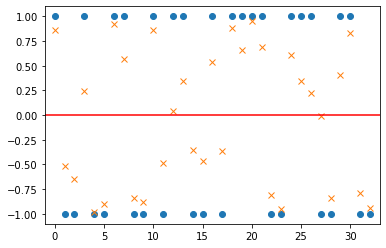

In [30]:
plt.xlim([-1, len(y_test)])
plt.plot(y_test, 'o')
plt.plot(prediction_values, 'x')
plt.axhline(y=0, color='r', linestyle='-')